# Vehicle Detection
 In this project we aim to detect vehicles on the road by using a pipeline that uses *HOG* gradient to extract features and *color transform*, we'll train an *SVG* classifier on cars and non car images to classify patches(windows) of an image, then run our pipeline on the project video to identify cars on the road.
 
 We'll achieve this by the help of these classes:
 * [`pipeline_methods.py`](./pipeline_methods.py)
 * [`P5.ipynb`](./P5.ipynb)
 * [`utils.py`](./utils.py)
 
**Note:** You can follow the notebook [`P5.ipynb`](./P5.ipynb) for a step by step of the project.

## Main Pipeline Components :

1. Features (Color, Raw, and HOG)
2. Classifier (Linear SVM)
3. Sliding window (Multi-scale) 
4. Tracking


# HOG (Histogram of Orientation Gradients)

We'll use HOG to extract meaningful features from both out training dataset and out video image patches. So 
![car_hog_image.png](./images/car_hog_image.png)

## RGB HOG

Here I tried HOG on all image channels, first I tried it on the `RGB` original image and got:

![all_car_hog_images.png](./images/all_car_hog_images.png)

Not bad, but then I tried other color spaces like the `LUV` which gave ok results. At last I found
that the `YCrCb` gives the best results overall and here's how it looks:


![all_car_hog_YCrCb_images.png](./images/all_car_hog_YCrCb_images.png)

Now we capture more features and the hog representation looks more like a car with the addition of the tail lights.
As we saw each channel captures a little bit more information than the others thats why I chose to collect `HOG` features from all channels during training and classification.

# Spacial Binning 

Here we include our raw pixel values, however we don't include the full size of it we resize our image and include a resized version of our image then we flatten it as a feature vector. This was achieved by the `bin_spatial()` method at line *line `39`* of the [`pipeline_methods.py`](./pipeline_methods.py).

![resized.png](./images/resized.png)


# Color Histogram

Color is one of the most important cues for any visual perception, so thats why we'll be using color as a feature in our feature vector. Here we calculate the color histogram for each channel

![rgb-histogram-plot.jpg](./images/rgb-histogram-plot.jpg)


`color_hist()` is the method responsible for calculating the image color histograms, it can be found at [`pipeline_methods.py`](./pipeline_methods.py) *line `47`*.


## Combining Features

To achieve the best result I combined *HOG*, *Raw binned features*, and *Color Histograms* to obtain my feature vector. My final parameters were: 
* A `YCrCb` color space
* `9` orientation, `8` pixels per cell, and `2` cells per block
* A `32x32` spacial bin size
* `16` histogram bins 


![image_hog.png](./images/image_hog.png)


the `pipeline_methods.single_img_features()` method computes the combined features of one, two, or all features, this method can be found at [`pipeline_methods.py`](./pipeline_methods.py) *line `113`* there is another variant of it that calculates the features over multiple images and this is the one that I used for extracting the training features. 

After combining all my features I got a features vector of `8,417` which is high, but hopefully its robust enough to correctly identify cars from non cars.


# Training 

After that I extracted the training images features and scaled the features using a `StandardScaler`, then trained on an `LinearSVM` model, and finally got a score of `98.54%` which is decent enough. Now if our accuracy was `92%` or `96%` that means that there is a chance that `8%` or `4%` of our windows would be misclassified which might be an issue depending on how many windows we're searching, thats why we should try to get our accuracy as high as we can. All training information can be found in the `Training an SVM Classifier` cells of the [`P5.ipynb`](./P5.ipynb) notebook.

# Sliding and Search Windows

Here we use a sliding window technique like the one we used in the *advanced lane lines detection*, but unlike the previous one we here extensively search the whole image and windows also overlap; something like Convolutions in ConvNets. 


The sliding window implementation is available in `pipeline_methods.slide_window()` at *line `187`*, and a demonstration of the method can be found at the `Window Search` cell in the [`P5.ipynb`](./P5.ipynb) notebook.

Here we slide a window over a part of the image from *y* `400` to `656` to be remove trees, the horizon, the hood of the car, and other irrelevant parts of the images that wont contain cars in them. Then I set a window overlap of `0.5` for optimal detection that will take time, but it yielded better results after a couple of tries.

After we create our windows we then search them and run the windows patches through our classifier using `pipeline_methods.search_windows()` which is found at *line `241`*, then we draw bounding boxes for the windows that were classified as car using the method `pipeline_methods.draw_boxes()` at *line `229`*. 
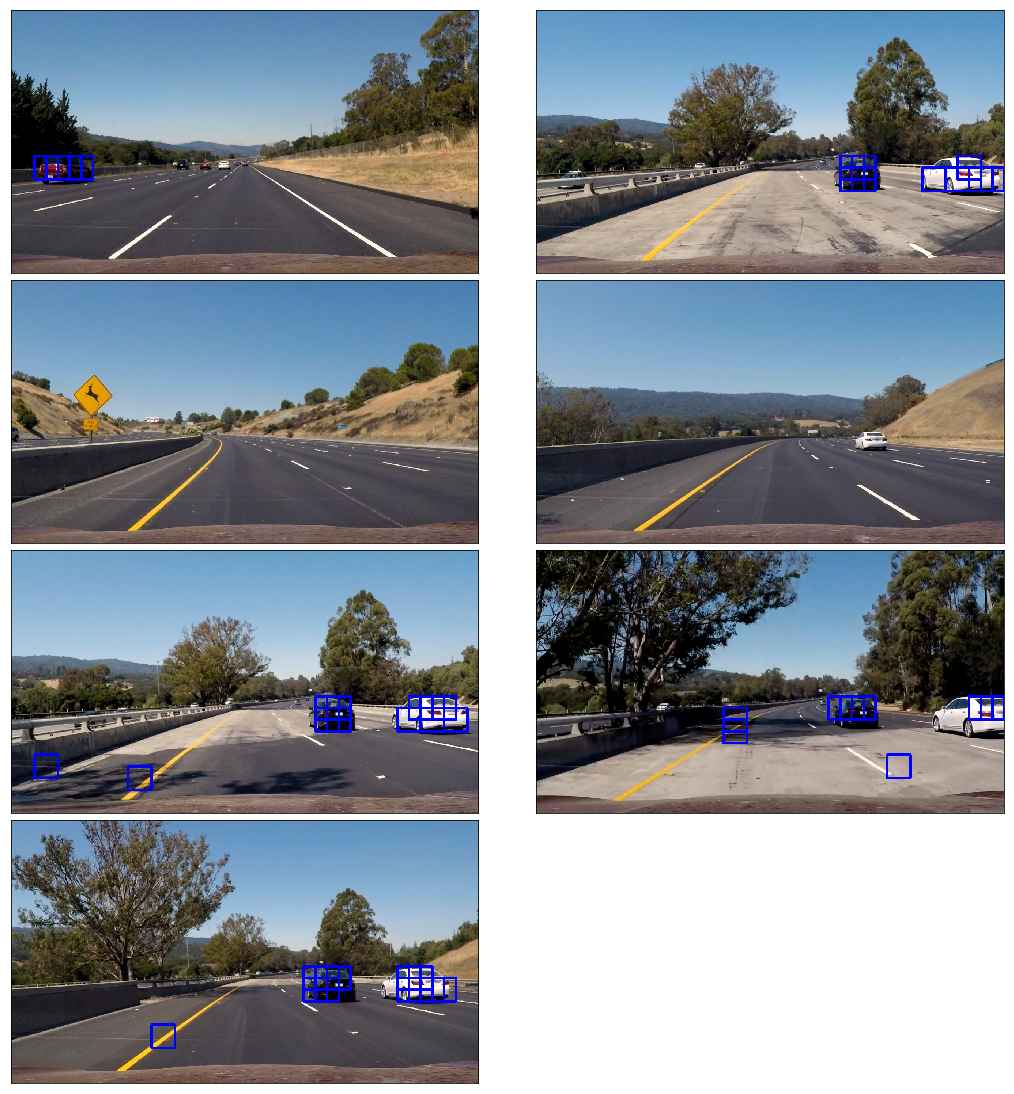


As we can see here we correctly identified the cars on the road, however, it seems that the `1.46%` is causing the classifier to misclassify some random parts of the image as cars.

# HOG Once and Heatmaps

Now we use `pipeline_methods.find_cars()` method to get cars in the image, this method combines all of the previous steps in one method one of the advantages of this method is that it computes the *HOG* features for the entire image once rather than computing *HOG* for each patch which is resource intensive and time consuming. 

After that we create a heat map for the detected windows and threshold the detections to remove false positives.

![finding_cars.png](./images/finding_cars.png)


But still we can find some false positives in the our images; we can eliminate some by increasing the threshold, but then we'll run the risk of removing some of our own positvely detected cars. 


# Averaging 

So for processing the video frames I'm averaging over `10` heat maps to get a more robust detection, I'm doing this by through the `pipeline_methods.RoadObjectFinder` detector class at *line `375`*. That class is really interesting it has an instance of the `adv_laneline_detection.LaneLineFinder` class and that enables the class to run both lane detection and car detection on the same frame and also use another approach that I'll be talking about below. Basically I sum up the last `10` heatmaps and set the threshold to a `40` which a high number that should eliminate any false positives that may arise even if they persist for a couple of frames this approach should eliminate any false positive.

# Deep Network

So I used a SegNet which is a Fully convolutional network that does pixel wise segmentation, this approach is really faster than the traditional computer vision based approach that I implemented above and if provided with good numerous data its generalizes better and yields better results. Below is a first step for applying deep learning to identify road objects and hopefully I'll improve upon it in the weeks to come.


## SegNet

Here I used a variant of [SegNet](http://mi.eng.cam.ac.uk/projects/segnet/) architecture, this model proved useful during the lyft challenge so I reused it for this project.

SegNet is a *FCN*(Fully Convolutional Network) that means that if you input an image you still get an image as a result. SegNet uses an auto encoder architecture where it has `5` encoder blocks that **shrink* the image and **extract** more features as we go deeper and a decoder which **upsamples** the image and **decrease** its features till it gets an image the same size as the input image, but this time it has a **softmax image** of the image labels.

I used the *VGG16 imagenet* pre-trained weights as the encoder, ignored *VGG16* fully connected layers, froze the weights to keep them constant while training, that will serve as my SegNet encoder. Then I added a mirroring decoder which is what will be trained on the new images.


![segnet.png](./images/segnet.png)


## Implementation 

The SegNet implementation `segnet()` can be found starting from  *line `138`* in [`kerasmodel.py`](./kerasmodel.py).

**Note:** All model code can be found at [`kerasmodel.py`](./kerasmodel.py).


## Data Collection and Preparation

I got the training data form the **Berekely Diverse Driving Video Database bdd100k** which was suggested by Michael Virgo, this database has many annotations which is appropriate for the segmentation task at hand. I combined Car segment images with the driving area segments and ended up with `3,425` images which is not much, so I applied a couple of augmentations to increase the number to `16,440` after a `20%` train test split. Then I combined the labels from different label images into a final 3 channel label image where the first channel (0) has the drivable area pixels, the second channel contains the car pixels, and the final channel had all other pixels as you can see here:

![final_labels.png](./images/final_labels.png)


I also manually labeled `53` images that I extracted extracted from the 3 project videos, I chose normal frames as well as some outliers like extreme brightness as is the case in the harder challenge video. Its a labor intensive process, but it was worth the effort for the `53` images helped the model on the videos after I retrained the network on the images.
I used a program called **Pixel Annotation Tool** which is basically a fancy paint, I also wrote a couple of scripts to combine images from different folders and to copy car and drivable area pixels from different label images to a single combined label image.

I also resized all of the training images and labels to `256x256` for a faster training and inception time.


## Training 

For training I did that on 2 times, the first was training the model on the `3,425` *bdd100k* dataset, then I trained the model on the manually extracted and labeled `53` images which was `264` after the validation split and augmentation. The mentioned approach added more accuracy for most of the videos, but it slightly overfit the small training data which made the model lack in certain areas where it previously hadn't, though it's still improved the overall performance.

### Additions
I'm planing to use more images to make the model more robust, in particular the CVPR_2018 data which has a combination of different datasets Cityspace for example.  


# Videos

## Computer Vision Outputs

### [Project Video](./videos/project_video.mp4)
### [Challenge Video](./videos/challenge_video.mp4)


## SegNet Outputs

### [Project Video](./videos/project_video_SEG.mp4)
### [Challenge Video](./videos/challenge_video_SEG.mp4)

## Conclusion 

This project was a continuation of identifying road instances, it was straight forward and I depended heavily on the lessons  in constructing my pipeline. I found that the techniques which mostly rely on computer vision tend to run slower than say a  deep neural network thats one of the reasons I tend to prefer deep learning techniques and pipelines more. I'm happy that both pipelines worked to an extent and it was fun playing around with images and tweaking multiple parameters to get a workable result.

## Potential Shortcomings
1. Better SVM accuracy 
2. More accurate Segmentation result

## Potential Solutions
1. Playing around more with the parameters and maybe also using the `C` and `gamma` *SVM* attributes.
2. More training on segmented data.

## Future Improvements
* I'm thinking of trying out **YOLOv3** which is an amazing deep classifier that identifies objects in an image and draws bounding boxes around them.